In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import numpy as np    
import matplotlib.image as mp
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import warnings
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self,drop,bm):
        super(Net, self).__init__()
        # 1 input image channel,  4 output channels, 5x5 square convolution
        #padding done so as to regain its original shape
        self.conv1 = nn.Conv2d(1, 4, 5,padding=2,padding_mode='reflect')
        # 1 input image channel,  4 output channels, 5x5x4 square convolution
        self.conv2 = nn.Conv2d(4, 4, 5,padding=2,padding_mode='reflect')
        self.layer1 = nn.Linear(196, 49) 
        if drop != 0 :
            self.layer2 = nn.Dropout(p=drop)
        self.layer3 = nn.Linear(49, 10)
        if bm != 0:
            self.layer4 = nn.BatchNorm1d(10)
    def forward(self, x,drop,bm):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = self.layer1(x)
        if drop != 0:
            x = self.layer2(x)
        x=F.relu(x)
        x = self.layer3(x)
        if bm != 0:
            x = self.layer4(x)
        return x

2022-04-20 23:35:50.362500: I tensorflow/core/util/util.cc:168] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-04-20 23:35:50.365197: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-20 23:35:50.365206: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

<h3>Function to shuffle the training data after each Epoch</h3>

In [3]:
def shuffle_func(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return np.array(a)[p], np.array(b)[p]

<h3>Function to plot TSNE for first Epoch and last Epoch</h3>

In [4]:
from sklearn.manifold import TSNE
def func_TSNE(output,labels,p): 
    warnings.filterwarnings('ignore')
    df = pd.DataFrame()
    final_TSNE_array = TSNE(n_components=2).fit_transform(output)
    df["y"] = labels
    df["Data[0]"] = final_TSNE_array[:,0]
    df["Data[1]"] = final_TSNE_array[:,1]
    sns.scatterplot(x="Data[0]", y="Data[1]", hue=df.y.tolist(),
                    palette=sns.color_palette("hls", 10),
                    data=df).set(title=" T-SNE projection for 100 image plots data coloured according to their labels after %d Epochs"%(p+1))
 
    plt.show()

<h3>Fucntion to choose optimizer depending upon x value(RMSprop,0),(optim.SGD,1) and (Momentum,2) </h3>

In [5]:
def optimizer_to_use(model,x):
    if x == 1:
        return optim.SGD(model.parameters(), lr=0.001)
    elif x == 2:
        return optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
    return optim.RMSprop(model.parameters(), lr=0.001, alpha = 0.9)
        

In [6]:
def getnimages(n,i):
    X = []
    Y = []
    numofimages = np.array([0]*10)
    while(not all(numofimages == n)):
        a = mnist_trainset[i][0]
        b = mnist_trainset[i][1]
        if(numofimages[b] < n):
            numofimages[b]+=1
            X.append([np.array(a)])
            Y.append(b)
        i+=1
    X = np.array(X)
    Y = np.array(Y)
    return X,Y,i

<h3>Function to calculate Error of Test set</h3>

In [7]:
def cal_error(model,X_test,Y_test,p,drop,bm):
    output1 = model(torch.Tensor(X_test),drop,bm)
    target1 = torch.LongTensor(Y_test)  # a dummy target, for example
    criterion = nn.CrossEntropyLoss()
    loss1 = criterion(output1, target1)
    _,predicted = output1.max(1)
    total = 0
    correct = 0
    total += target1.size(0)
    correct += predicted.eq(target1).sum().item()
    accu=correct/total
    if p == 0 or p == 14 :
        func_TSNE(output1.detach().numpy(),target1.detach().numpy(),p)
    return model,accu,loss1

<h3>Function to print slice of kernel for 2 convolutions</h3>

In [8]:
def kernel_print(model):
    fig = plt.figure(figsize=(10, 7))
    fig.add_subplot(2,2,1)
    plt.imshow(list(model.parameters())[0].detach().numpy()[0][0],cmap='gray')#plotting the image
    plt.title("slice of Kernel for 1st Convolution")
    fig.add_subplot(2,2,2)
    plt.imshow(list(model.parameters())[2].detach().numpy()[0][0],cmap='gray')#plotting the image
    plt.title("slice of Kernel for 2nd Convolution")
    plt.show()


<h3>Extracting Images from the dataset</h3>

In [9]:
X_data,Y_label,m=getnimages(100,0)#training with 400 images
X_test,Y_test,m =getnimages(10,m)
print(X_data.shape)

(1000, 1, 28, 28)


<h3>Function to plot train error and test error vs No of Epochs</h3>

In [10]:
import matplotlib.pyplot as plt
def fig_analyse(train_lo,test_lo):
    plt.plot(train_lo,color='r',marker='o',label = "Train error")
    plt.plot(test_lo,color='b',marker='o',label = "Test error")
    plt.xlabel("No of Epochs")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

<h3>Class to define and execute complete model</h3>

In [11]:
def Network_model(model,X_data,Y_label,X_test,Y_test,x,drop,bm,epochs):
    batch_size = 10
    n = 100
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_to_use(model,x)
    train_lo = []
    test_lo = []
    for p in range(epochs):           
        X_data,Y_label=shuffle_func(X_data,Y_label)
        accu=0
        total = 0
        correct = 0
        train_loss = 0
        for i in range(n):
            running_loss = 0
            output = model(torch.Tensor(X_data[i*batch_size:(i+1)*batch_size]),drop,bm)
            target = torch.LongTensor(Y_label[i*batch_size:(i+1)*batch_size])  # a dummy target, for example
            optimizer.zero_grad()
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            _,predicted = output.max(1)
            running_loss += loss.item()
            train_loss += running_loss/batch_size
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            accu+=correct/total
        model,accu1,loss1 = cal_error(model,X_test,Y_test,p,drop,bm)
        train_lo.append(train_loss/n)
        test_lo.append(loss1.detach().numpy())
        print("\nEpoch:",p+1)
        kernel_print(model)
        print('Train Accuracy:',accu/n,'Train Loss:',train_loss/n)
        print('Test Accuracy:',accu1,'Test Loss:',loss1.detach().numpy())
    print("Final accuracy of the classifier:",accu1)        
    return model,train_lo,test_lo

<h3>Considering the optimizer as RMSProp without any batch normalization and Dropout where classifier accuracy,TSNE plot are printed at last</h3>

While using RMSProp without any batch normalization and Dropout


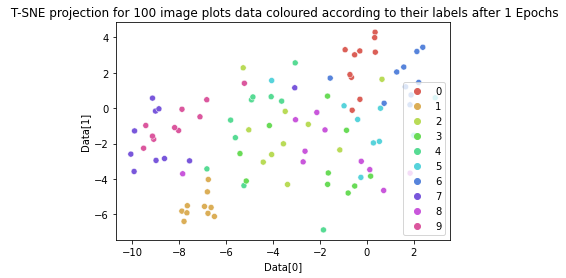


Epoch: 1


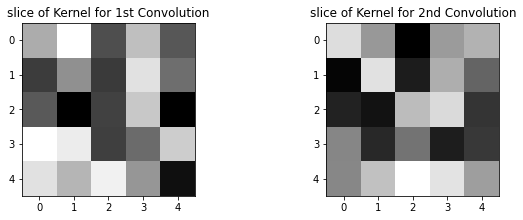

Train Accuracy: 0.3780405215127617 Train Loss: 0.16270839053392414
Test Accuracy: 0.67 Test Loss: 1.0041814

Epoch: 2


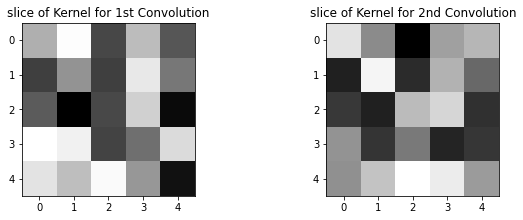

Train Accuracy: 0.8390293989958895 Train Loss: 0.05474805631116032
Test Accuracy: 0.67 Test Loss: 1.06126

Epoch: 3


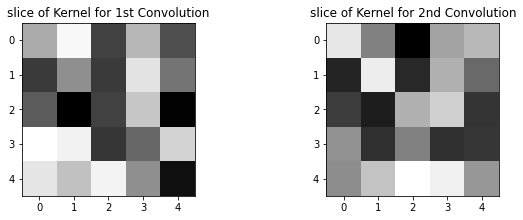

Train Accuracy: 0.8769445209472283 Train Loss: 0.036812222174368796
Test Accuracy: 0.82 Test Loss: 0.53276366

Epoch: 4


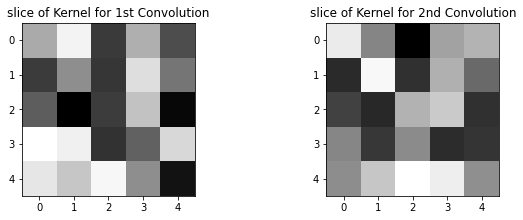

Train Accuracy: 0.9347000060958831 Train Loss: 0.023814050209475676
Test Accuracy: 0.85 Test Loss: 0.5159124

Epoch: 5


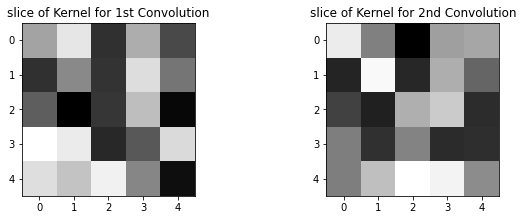

Train Accuracy: 0.9520885270439937 Train Loss: 0.01641205460671336
Test Accuracy: 0.83 Test Loss: 0.62008494

Epoch: 6


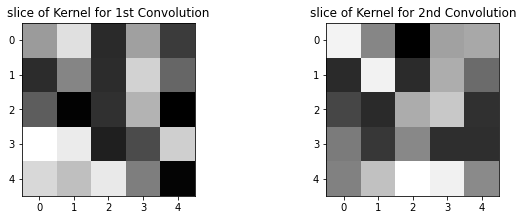

Train Accuracy: 0.9646019665147714 Train Loss: 0.012063487107288894
Test Accuracy: 0.88 Test Loss: 0.48997796

Epoch: 7


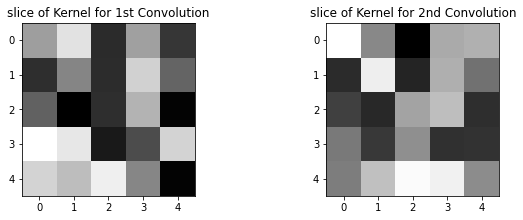

Train Accuracy: 0.978194016740171 Train Loss: 0.007983820044784805
Test Accuracy: 0.87 Test Loss: 0.5127031

Epoch: 8


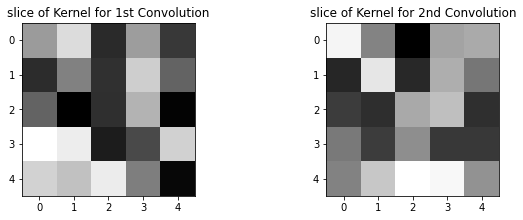

Train Accuracy: 0.9877360388186996 Train Loss: 0.00548761603499588
Test Accuracy: 0.84 Test Loss: 0.8798119

Epoch: 9


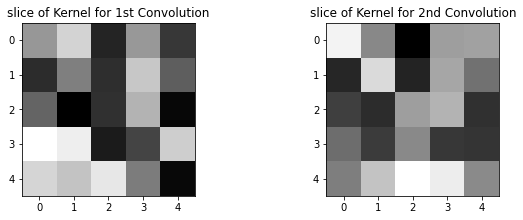

Train Accuracy: 0.989395691000185 Train Loss: 0.0041236782113837755
Test Accuracy: 0.89 Test Loss: 0.69414735

Epoch: 10


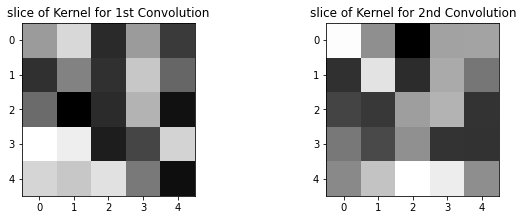

Train Accuracy: 0.9931727145512528 Train Loss: 0.003821778323865147
Test Accuracy: 0.86 Test Loss: 0.662192

Epoch: 11


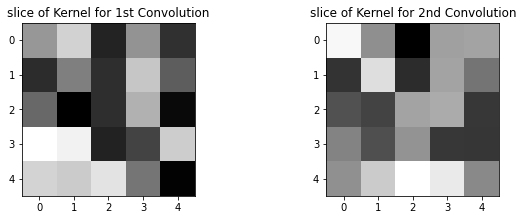

Train Accuracy: 0.9949321815836634 Train Loss: 0.0019928517371727134
Test Accuracy: 0.85 Test Loss: 1.2544273

Epoch: 12


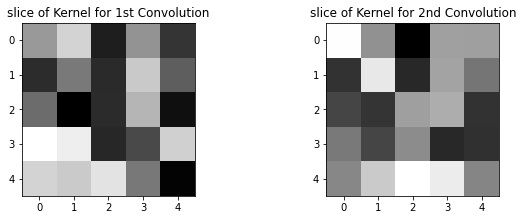

Train Accuracy: 0.9953045992537976 Train Loss: 0.0013855890253485085
Test Accuracy: 0.85 Test Loss: 0.84941614

Epoch: 13


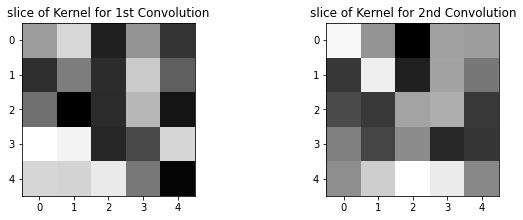

Train Accuracy: 0.989187443495258 Train Loss: 0.002102835667453291
Test Accuracy: 0.89 Test Loss: 0.669499

Epoch: 14


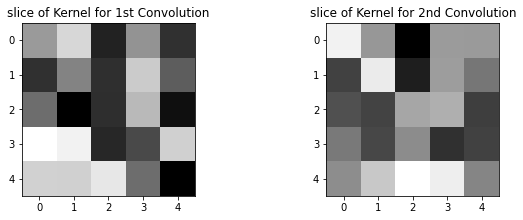

Train Accuracy: 0.9945358469118133 Train Loss: 0.003485566126602294
Test Accuracy: 0.86 Test Loss: 0.88688964


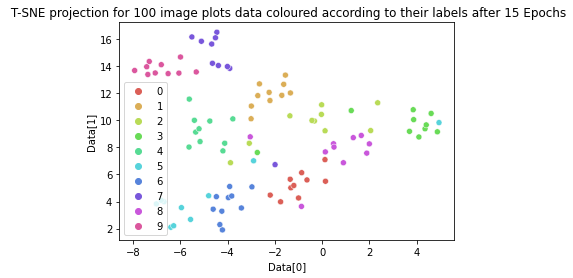


Epoch: 15


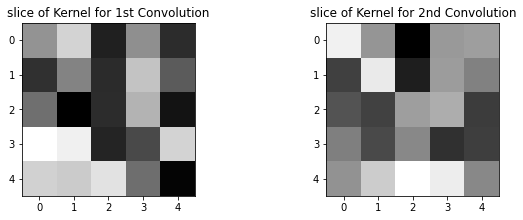

Train Accuracy: 1.0 Train Loss: 0.00029007605246540545
Test Accuracy: 0.83 Test Loss: 1.2384225
Final accuracy of the classifier: 0.83


In [35]:
epochs = 15
model = Net(0,0)
print("While using RMSProp without any batch normalization and Dropout")
model,train_lo,test_lo = Network_model(model,X_data,Y_label,X_test,Y_test,0,0,0,epochs)

<h3>Analysing the train and Test error for the above model and plotting it W.R.T to Epochs </h3>

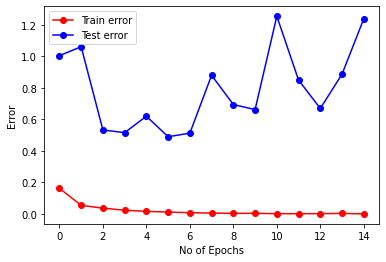

In [36]:
fig_analyse(train_lo,test_lo)

<h3>Considering the optimizer as Vanilla SGD without any batch normalization and Dropout where classifier accuracy,TSNE plot are printed at last</h3>

While using Vanilla SGD without any batch normalization and Dropout


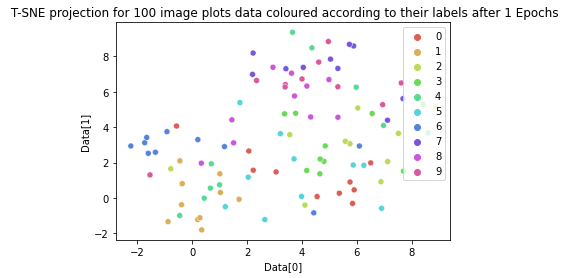


Epoch: 1


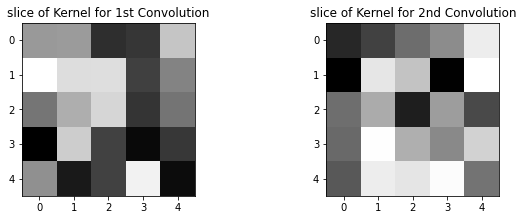

Train Accuracy: 0.18859536004791266 Train Loss: 0.2095805358886719
Test Accuracy: 0.43 Test Loss: 1.5978234

Epoch: 2


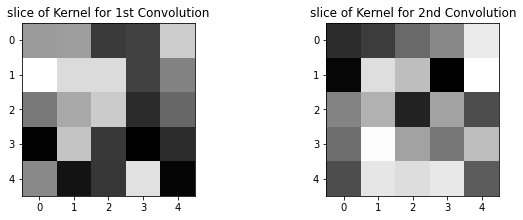

Train Accuracy: 0.5917053736507255 Train Loss: 0.10600417914986608
Test Accuracy: 0.73 Test Loss: 0.84286547

Epoch: 3


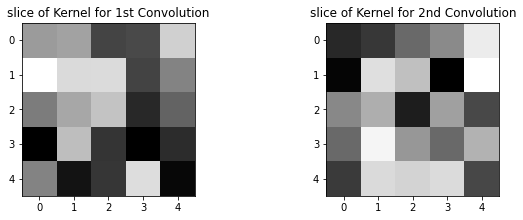

Train Accuracy: 0.7913364381417939 Train Loss: 0.05470102011784914
Test Accuracy: 0.77 Test Loss: 0.62604415

Epoch: 4


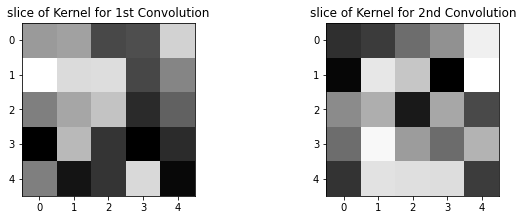

Train Accuracy: 0.8930913709464242 Train Loss: 0.03733125188015404
Test Accuracy: 0.83 Test Loss: 0.5063245

Epoch: 5


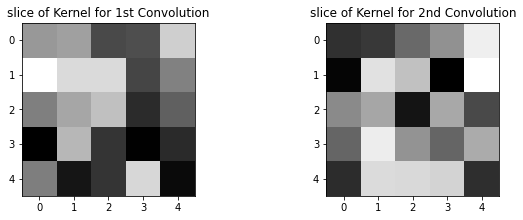

Train Accuracy: 0.9461313171365717 Train Loss: 0.027089235128834856
Test Accuracy: 0.83 Test Loss: 0.5068329

Epoch: 6


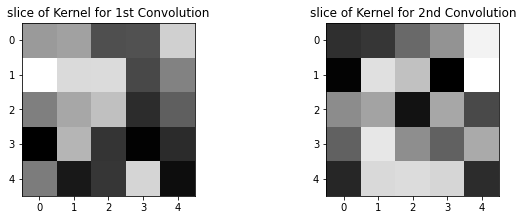

Train Accuracy: 0.9655326337833965 Train Loss: 0.020600694833323357
Test Accuracy: 0.81 Test Loss: 0.45033404

Epoch: 7


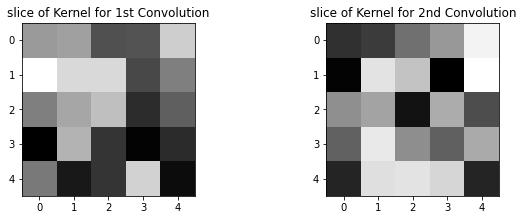

Train Accuracy: 0.9613666378256167 Train Loss: 0.016787179281003782
Test Accuracy: 0.84 Test Loss: 0.45904064

Epoch: 8


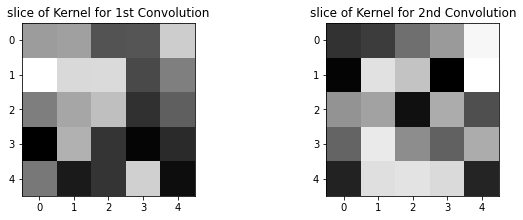

Train Accuracy: 0.959296361410217 Train Loss: 0.012059064222266894
Test Accuracy: 0.84 Test Loss: 0.49519426

Epoch: 9


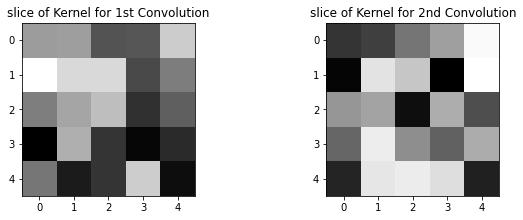

Train Accuracy: 0.9688713975437097 Train Loss: 0.010414718495914714
Test Accuracy: 0.82 Test Loss: 0.45013443

Epoch: 10


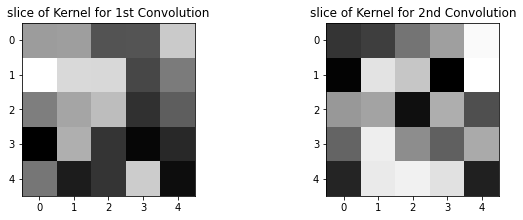

Train Accuracy: 0.9932825205034728 Train Loss: 0.007721279782708731
Test Accuracy: 0.85 Test Loss: 0.46887302

Epoch: 11


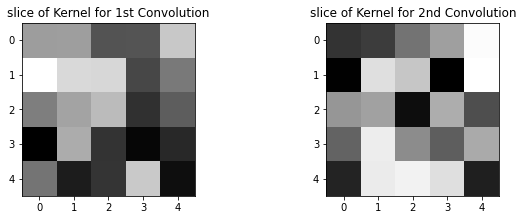

Train Accuracy: 0.9831878561058229 Train Loss: 0.006063044967013412
Test Accuracy: 0.85 Test Loss: 0.43908322

Epoch: 12


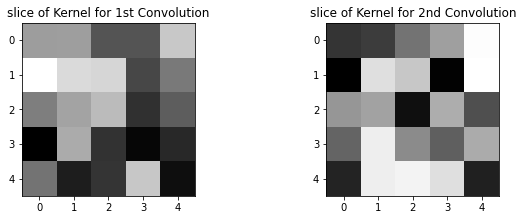

Train Accuracy: 0.9947611817292011 Train Loss: 0.004747786503518
Test Accuracy: 0.86 Test Loss: 0.4803419

Epoch: 13


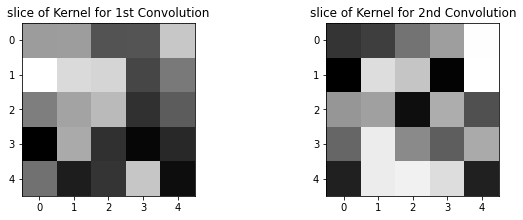

Train Accuracy: 0.9923338662652457 Train Loss: 0.003567696695259657
Test Accuracy: 0.85 Test Loss: 0.4320337

Epoch: 14


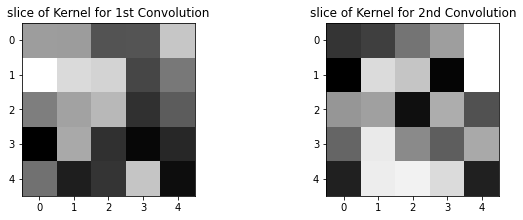

Train Accuracy: 0.9959377836363837 Train Loss: 0.0027269631953677157
Test Accuracy: 0.88 Test Loss: 0.46016717


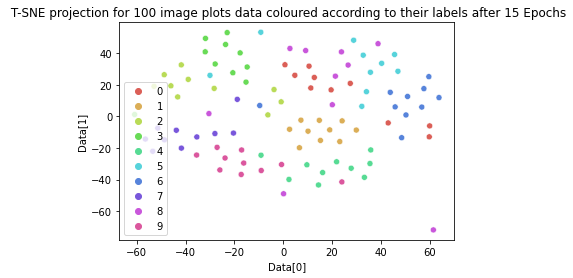


Epoch: 15


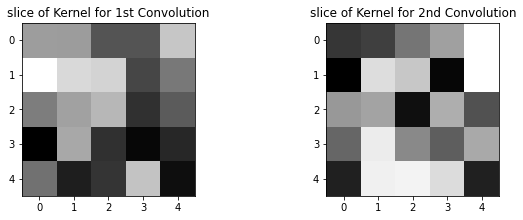

Train Accuracy: 0.9970843350974463 Train Loss: 0.00234121502187918
Test Accuracy: 0.86 Test Loss: 0.4570148
Final accuracy of the classifier: 0.86


In [37]:
model = Net(0,0)
print("While using Vanilla SGD without any batch normalization and Dropout")
model,train_lo,test_lo = Network_model(model,X_data,Y_label,X_test,Y_test,1,0,0,epochs)



<h3>Analysing the train and Test error for the above model and plotting it W.R.T to Epochs </h3>

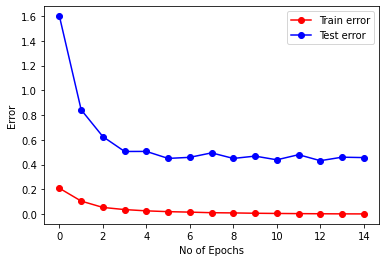

In [38]:
fig_analyse(train_lo,test_lo)

<h3>Considering the optimizer as Momentum without any batch normalization and Dropout where classifier accuracy,TSNE plot are printed at last</h3>

While using Momentum without any batch normalization and Dropout


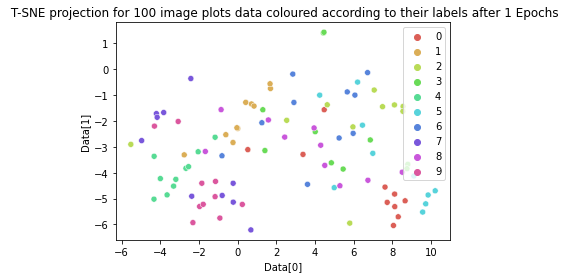


Epoch: 1


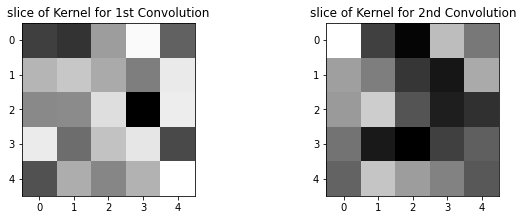

Train Accuracy: 0.17774124882835732 Train Loss: 0.19646070593595508
Test Accuracy: 0.49 Test Loss: 1.7850424

Epoch: 2


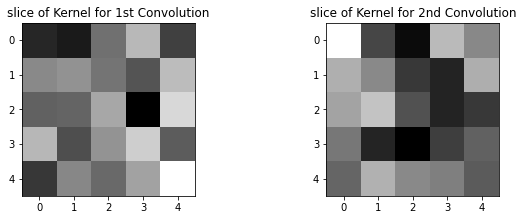

Train Accuracy: 0.6456550531056101 Train Loss: 0.09493826454132794
Test Accuracy: 0.66 Test Loss: 1.1993337

Epoch: 3


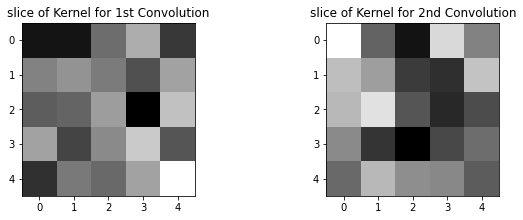

Train Accuracy: 0.7585459460056478 Train Loss: 0.061275758291594686
Test Accuracy: 0.69 Test Loss: 1.0417882

Epoch: 4


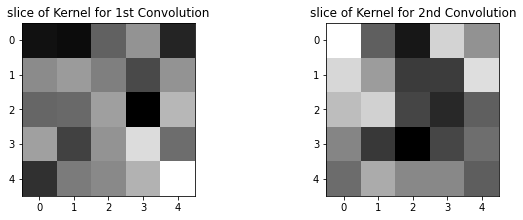

Train Accuracy: 0.826874237711512 Train Loss: 0.048352296929806464
Test Accuracy: 0.71 Test Loss: 1.0639989

Epoch: 5


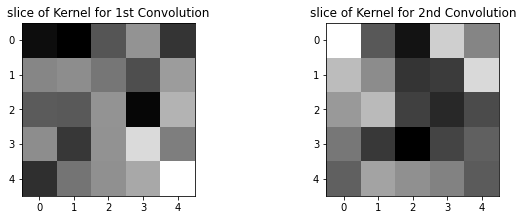

Train Accuracy: 0.8745623059936862 Train Loss: 0.04244322190247478
Test Accuracy: 0.82 Test Loss: 0.6083777

Epoch: 6


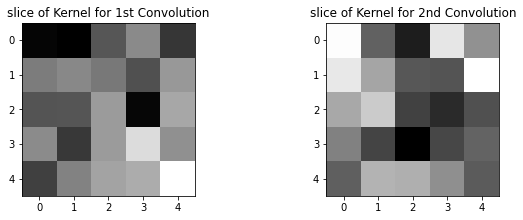

Train Accuracy: 0.9094388845311018 Train Loss: 0.02806629340117798
Test Accuracy: 0.77 Test Loss: 0.77833503

Epoch: 7


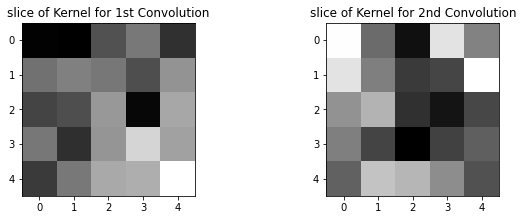

Train Accuracy: 0.9153978021480377 Train Loss: 0.025319007609854456
Test Accuracy: 0.76 Test Loss: 0.7697107

Epoch: 8


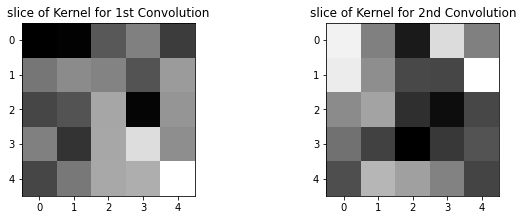

Train Accuracy: 0.9398752744089104 Train Loss: 0.023715380288078448
Test Accuracy: 0.83 Test Loss: 0.6824125

Epoch: 9


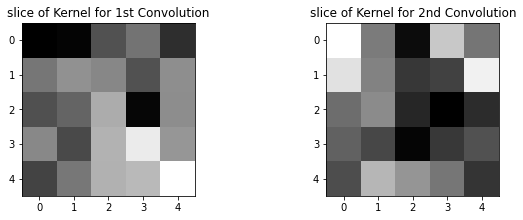

Train Accuracy: 0.9331547752939341 Train Loss: 0.02150408098960178
Test Accuracy: 0.71 Test Loss: 1.4280537

Epoch: 10


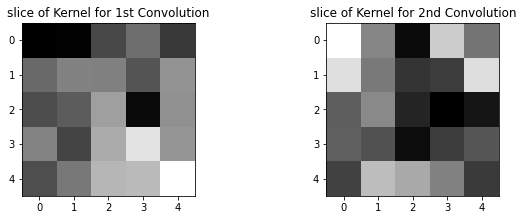

Train Accuracy: 0.9568323045218656 Train Loss: 0.015428479944210267
Test Accuracy: 0.83 Test Loss: 1.2288673

Epoch: 11


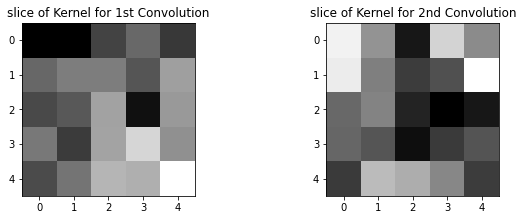

Train Accuracy: 0.9656614550391355 Train Loss: 0.016497643502138084
Test Accuracy: 0.75 Test Loss: 1.1951153

Epoch: 12


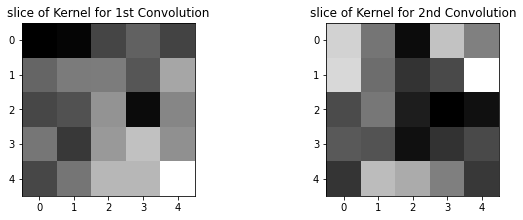

Train Accuracy: 0.9103238061060839 Train Loss: 0.023215134034166106
Test Accuracy: 0.78 Test Loss: 1.3549974

Epoch: 13


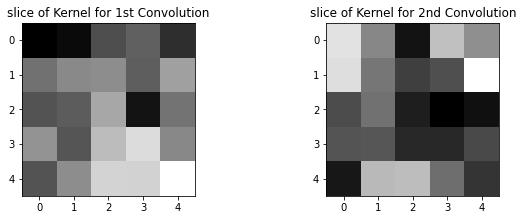

Train Accuracy: 0.934282716408817 Train Loss: 0.022524530110327762
Test Accuracy: 0.82 Test Loss: 0.84406066

Epoch: 14


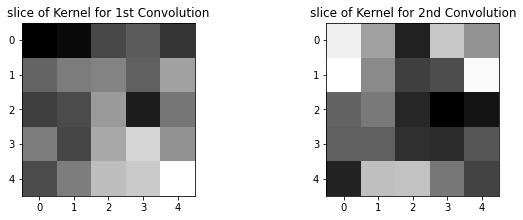

Train Accuracy: 0.9529847767981472 Train Loss: 0.012198710399891753
Test Accuracy: 0.81 Test Loss: 0.97827095


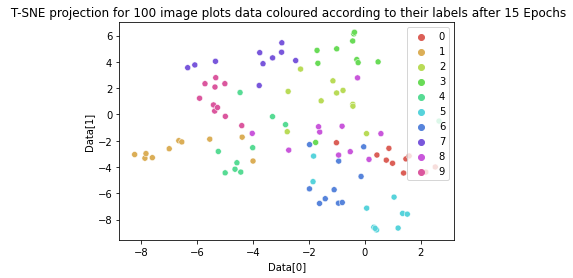


Epoch: 15


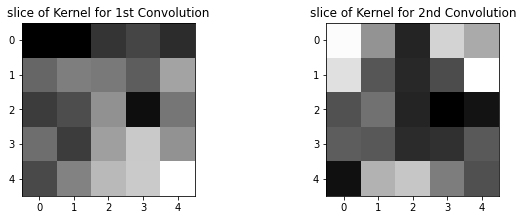

Train Accuracy: 0.9543309660268003 Train Loss: 0.019999525158789767
Test Accuracy: 0.78 Test Loss: 1.0035541
Final accuracy of the classifier: 0.78


In [39]:
model = Net(0,0)
print("While using Momentum without any batch normalization and Dropout")
model,train_lo,test_lo = Network_model(model,X_data,Y_label,X_test,Y_test,2,0,0,epochs)


<h3>Analysing the train and Test error for the above model and plotting it W.R.T to Epochs </h3>

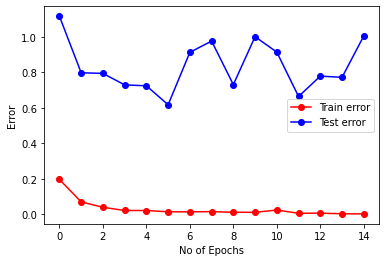

In [17]:
fig_analyse(train_lo,test_lo)

<h2>Observations from plots for 2,3Q</h2>
<h4>As we can see clearly from the classifier accuracy values of above 3 models where optimizers are being changed where initially we used RMSprop, Vanilla SGD and atlast Momentum. we can see that the accuracy is increased from 0.83 to 0.86 when we changed optimizer from RMSprop to Vanilla SGD and it decreased from 0.86 to 0.78 when we changed the optimizer from Vanilla SGD to Momentum. so from the above accuarcy values we can state the accuracy values are Vanilla SGD>RMSprop>Momentum</h4>

<h3>Considering only Dropout with value 0.2 with RMSprop where classifier accuracy,TSNE plot are printed at last</h3>

Considering only Dropout with value 0.2


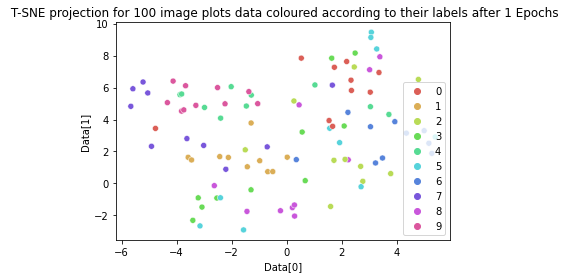


Epoch: 1


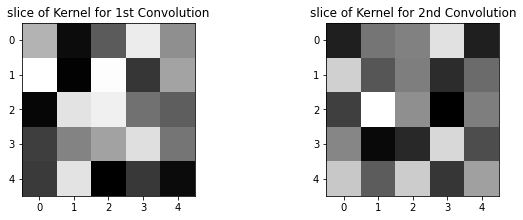

Train Accuracy: 0.31333859008427767 Train Loss: 0.18454093945026392
Test Accuracy: 0.63 Test Loss: 1.2837174

Epoch: 2


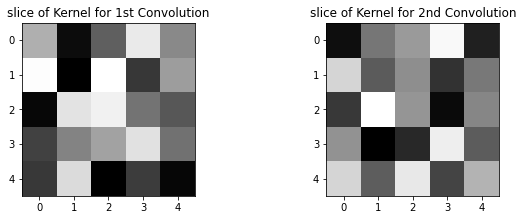

Train Accuracy: 0.7640276664132267 Train Loss: 0.07309053557738661
Test Accuracy: 0.73 Test Loss: 0.9549952

Epoch: 3


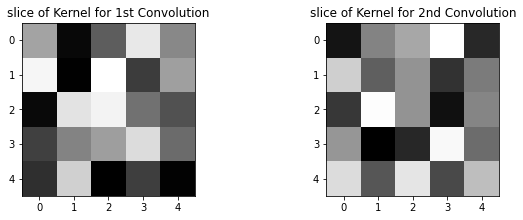

Train Accuracy: 0.8407326617002374 Train Loss: 0.04842426038905976
Test Accuracy: 0.85 Test Loss: 0.5517336

Epoch: 4


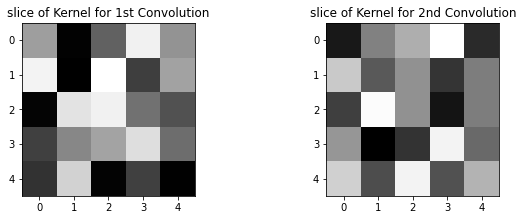

Train Accuracy: 0.91199747810845 Train Loss: 0.034564617421478025
Test Accuracy: 0.8 Test Loss: 0.71905947

Epoch: 5


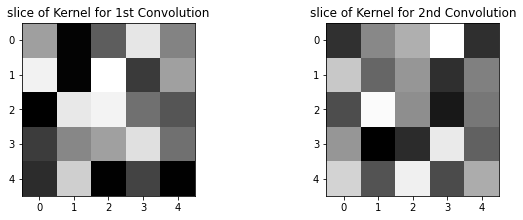

Train Accuracy: 0.8900037242747695 Train Loss: 0.024724958536215133
Test Accuracy: 0.74 Test Loss: 0.5953866

Epoch: 6


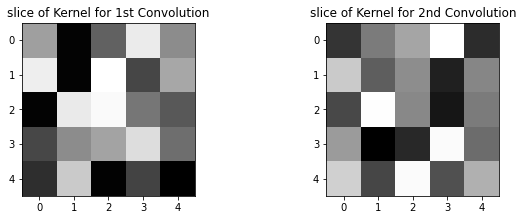

Train Accuracy: 0.92744964030471 Train Loss: 0.021066924289101726
Test Accuracy: 0.83 Test Loss: 0.49860206

Epoch: 7


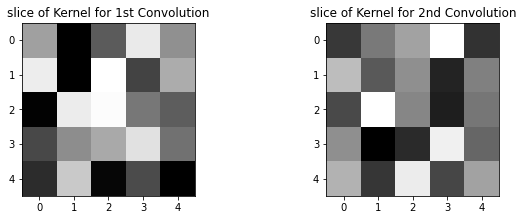

Train Accuracy: 0.9586931271041952 Train Loss: 0.01601126088098681
Test Accuracy: 0.87 Test Loss: 0.4430783

Epoch: 8


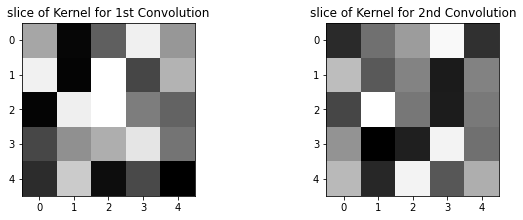

Train Accuracy: 0.9650244427403654 Train Loss: 0.014211571421474223
Test Accuracy: 0.83 Test Loss: 0.49729908

Epoch: 9


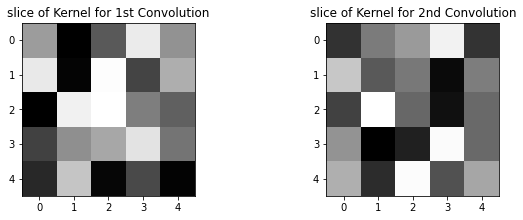

Train Accuracy: 0.9599124605964983 Train Loss: 0.011894858844287225
Test Accuracy: 0.82 Test Loss: 0.5893816

Epoch: 10


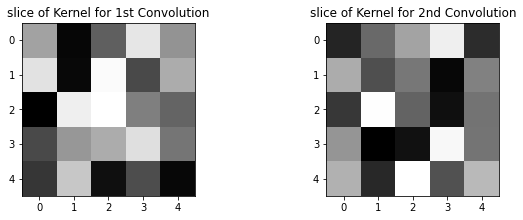

Train Accuracy: 0.9730717211275691 Train Loss: 0.011483484840748135
Test Accuracy: 0.87 Test Loss: 0.6377649

Epoch: 11


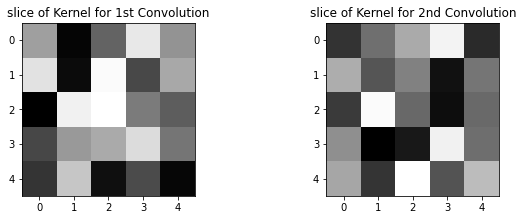

Train Accuracy: 0.9702502187312549 Train Loss: 0.00913459896015411
Test Accuracy: 0.8 Test Loss: 0.9339128

Epoch: 12


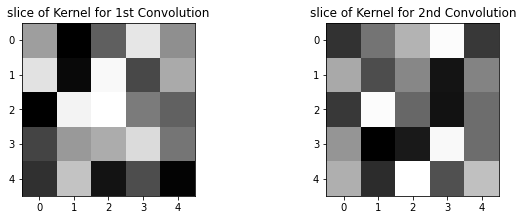

Train Accuracy: 0.971264289695736 Train Loss: 0.009505163138806437
Test Accuracy: 0.91 Test Loss: 0.5615251

Epoch: 13


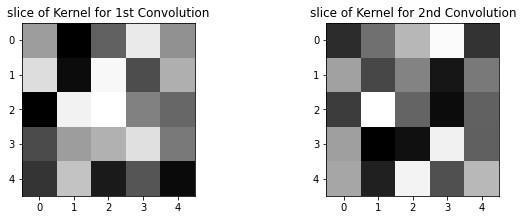

Train Accuracy: 0.9832472931620422 Train Loss: 0.0065179637680830614
Test Accuracy: 0.88 Test Loss: 0.5294633

Epoch: 14


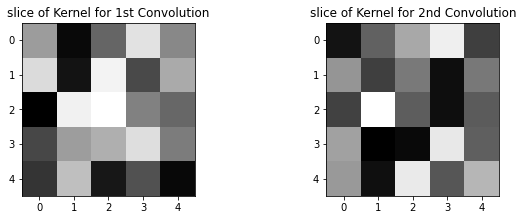

Train Accuracy: 0.9840062323422586 Train Loss: 0.005896318188239091
Test Accuracy: 0.83 Test Loss: 0.83739173


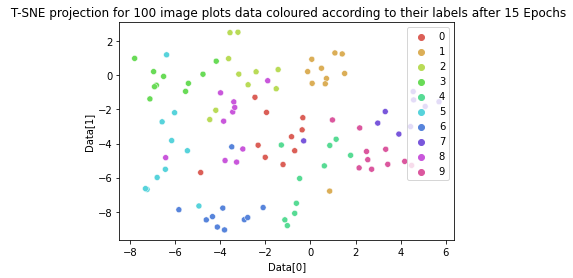


Epoch: 15


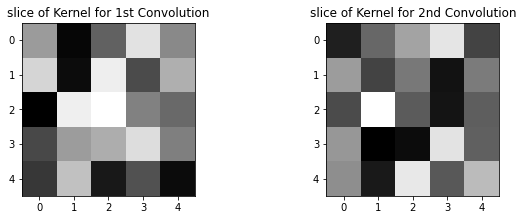

Train Accuracy: 0.9810867041185464 Train Loss: 0.006396974848682475
Test Accuracy: 0.89 Test Loss: 0.6197131
Final accuracy of the classifier: 0.89


In [33]:
print("Considering only Dropout with value 0.2")
model1 = Net(0.2,0)
model1,train_lo,test_lo = Network_model(model1,X_data,Y_label,X_test,Y_test,0,0.2,0,epochs)


<h3>Analysing the train and Test error for the above model and plotting it W.R.T to Epochs </h3>

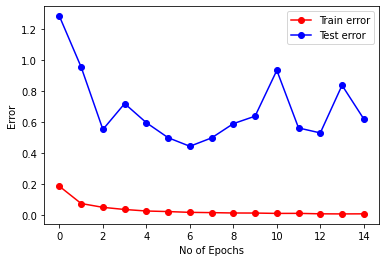

In [34]:
fig_analyse(train_lo,test_lo)

<h3>Considering only Dropout with value 0.5 with RMSprop where classifier accuracy,TSNE plot are printed at last</h3>

Considering only Dropout with value 0.5


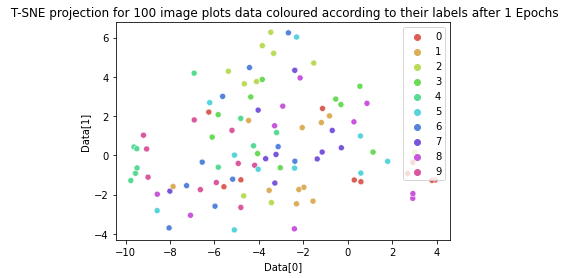


Epoch: 1


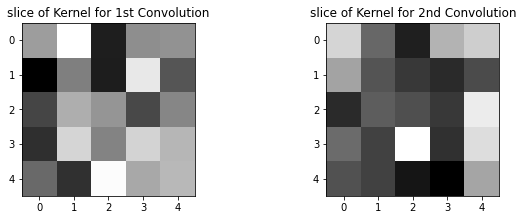

Train Accuracy: 0.20116367129525348 Train Loss: 0.2456522258520128
Test Accuracy: 0.54 Test Loss: 1.6220322

Epoch: 2


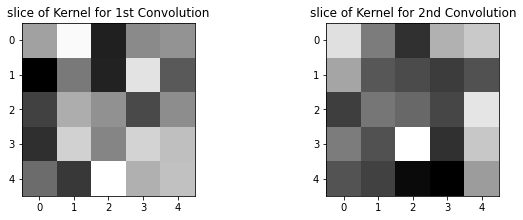

Train Accuracy: 0.5505867412630426 Train Loss: 0.1263516603708267
Test Accuracy: 0.7 Test Loss: 1.1576809

Epoch: 3


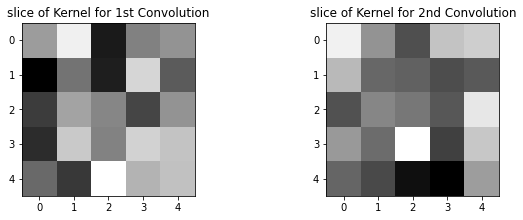

Train Accuracy: 0.7034263683849027 Train Loss: 0.08670629155635831
Test Accuracy: 0.64 Test Loss: 1.1159073

Epoch: 4


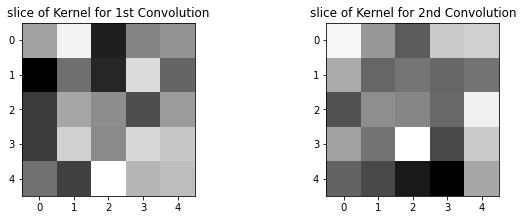

Train Accuracy: 0.7748455513195496 Train Loss: 0.07235224028676748
Test Accuracy: 0.68 Test Loss: 0.88238525

Epoch: 5


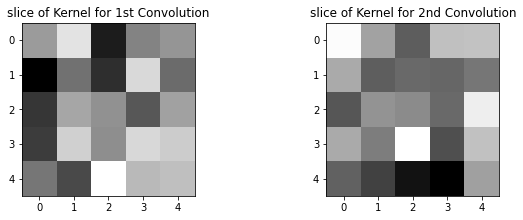

Train Accuracy: 0.851026030626009 Train Loss: 0.05398425641655922
Test Accuracy: 0.68 Test Loss: 0.84527856

Epoch: 6


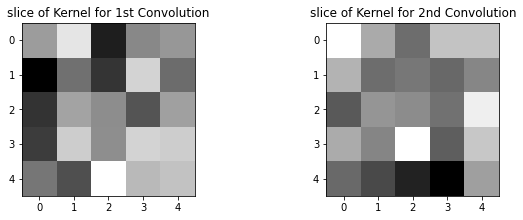

Train Accuracy: 0.8684088690565507 Train Loss: 0.0500335021559149
Test Accuracy: 0.74 Test Loss: 0.86360955

Epoch: 7


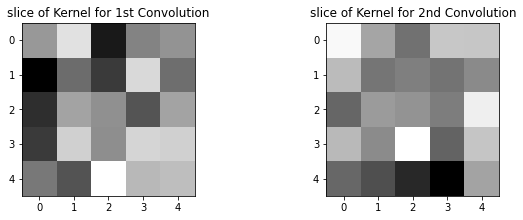

Train Accuracy: 0.8543614441513689 Train Loss: 0.04152480793185532
Test Accuracy: 0.8 Test Loss: 0.6591698

Epoch: 8


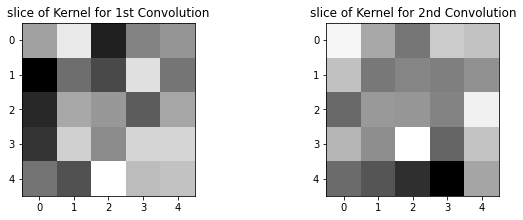

Train Accuracy: 0.8640668250387507 Train Loss: 0.03613489929214119
Test Accuracy: 0.81 Test Loss: 0.7761121

Epoch: 9


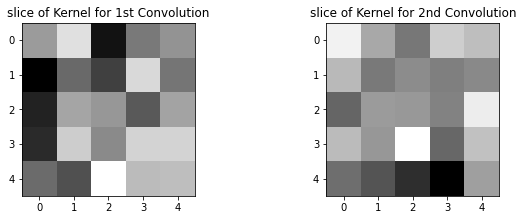

Train Accuracy: 0.8902908109263673 Train Loss: 0.03634092508861796
Test Accuracy: 0.82 Test Loss: 0.6380501

Epoch: 10


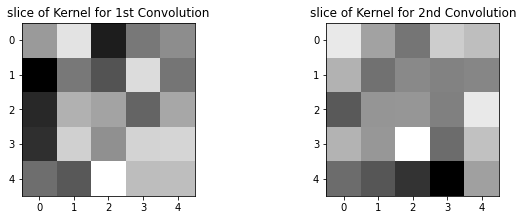

Train Accuracy: 0.9058659136540852 Train Loss: 0.02706106600887143
Test Accuracy: 0.8 Test Loss: 0.63041157

Epoch: 11


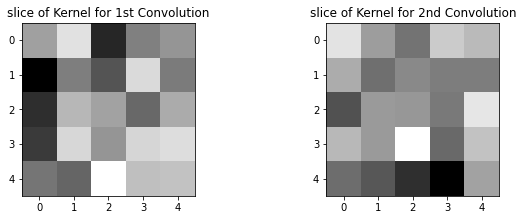

Train Accuracy: 0.8854840885601911 Train Loss: 0.03213750300416724
Test Accuracy: 0.81 Test Loss: 0.54003143

Epoch: 12


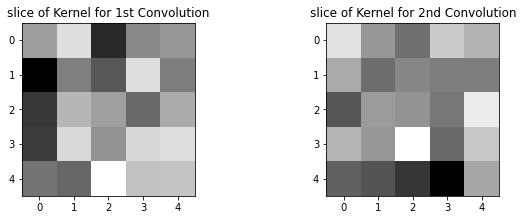

Train Accuracy: 0.9022318460247967 Train Loss: 0.02666368486918509
Test Accuracy: 0.82 Test Loss: 0.83355254

Epoch: 13


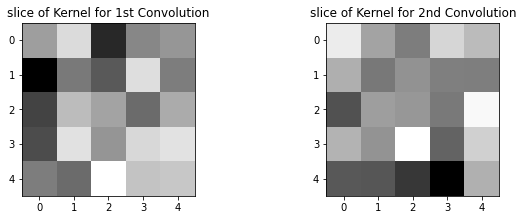

Train Accuracy: 0.9243241793151562 Train Loss: 0.021036032929405347
Test Accuracy: 0.76 Test Loss: 0.91557

Epoch: 14


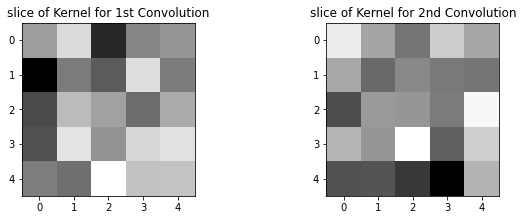

Train Accuracy: 0.9098747288523552 Train Loss: 0.024912950242287478
Test Accuracy: 0.87 Test Loss: 0.66046494


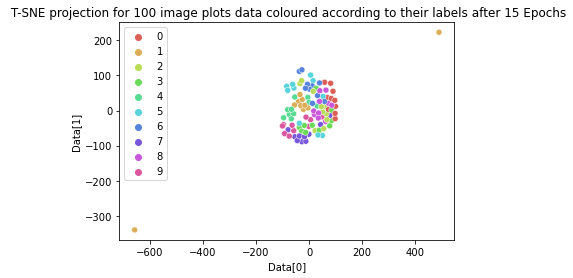


Epoch: 15


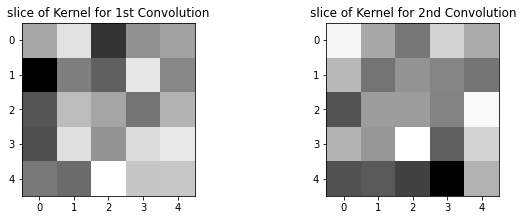

Train Accuracy: 0.920104483228048 Train Loss: 0.022578766868798988
Test Accuracy: 0.8 Test Loss: 0.8542019
Final accuracy of the classifier: 0.8


In [32]:
print("Considering only Dropout with value 0.5")
model1 = Net(0.5,0)
model1,train_lo,test_lo = Network_model(model1,X_data,Y_label,X_test,Y_test,0,0.5,0,epochs)


<h3>Analysing the train and Test error for the above model and plotting it W.R.T to Epochs </h3>

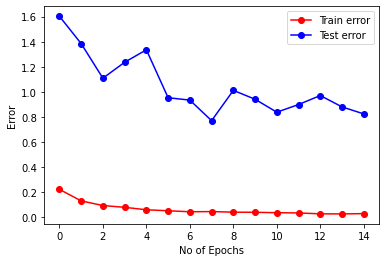

In [31]:
fig_analyse(train_lo,test_lo)

<h3>Considering only Dropout with value 0.8 with RMSprop where classifier accuracy,TSNE plot are printed at last</h3>

Considering only Dropout with value 0.8


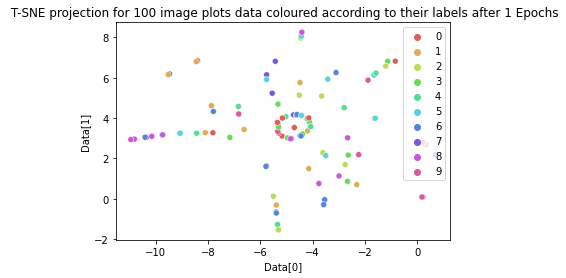


Epoch: 1


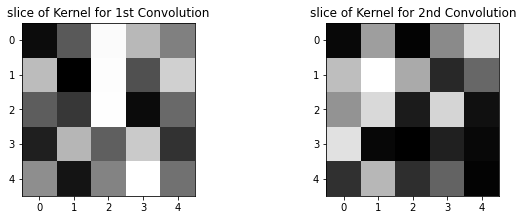

Train Accuracy: 0.13312946793653435 Train Loss: 0.27902768433094033
Test Accuracy: 0.16 Test Loss: 2.3289382

Epoch: 2


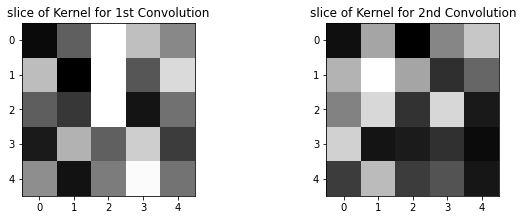

Train Accuracy: 0.24569477067676335 Train Loss: 0.20874155938625327
Test Accuracy: 0.19 Test Loss: 2.2757626

Epoch: 3


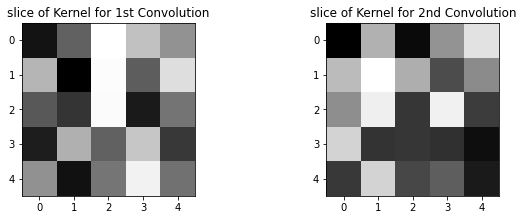

Train Accuracy: 0.2668014545062009 Train Loss: 0.18901149356365207
Test Accuracy: 0.36 Test Loss: 1.8511221

Epoch: 4


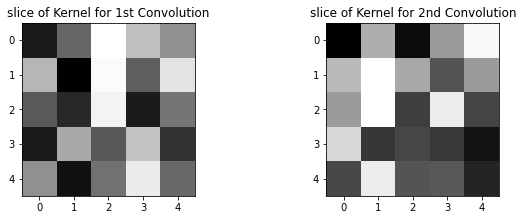

Train Accuracy: 0.3403933871282074 Train Loss: 0.1775230711102486
Test Accuracy: 0.4 Test Loss: 1.7200882

Epoch: 5


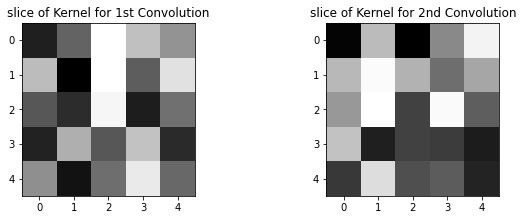

Train Accuracy: 0.3878339475094566 Train Loss: 0.15940691369771962
Test Accuracy: 0.35 Test Loss: 1.9132419

Epoch: 6


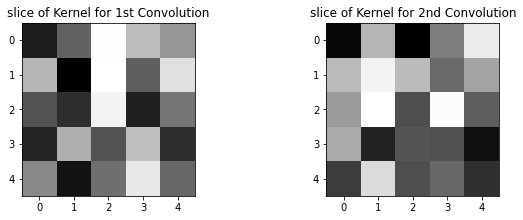

Train Accuracy: 0.451212101828978 Train Loss: 0.15590554600954054
Test Accuracy: 0.38 Test Loss: 1.8791797

Epoch: 7


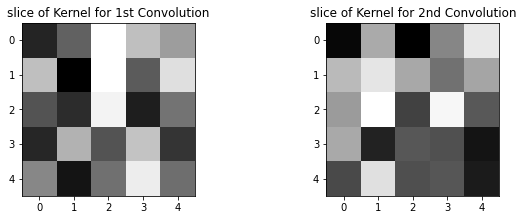

Train Accuracy: 0.47334867757405014 Train Loss: 0.14323259806633
Test Accuracy: 0.39 Test Loss: 1.8199724

Epoch: 8


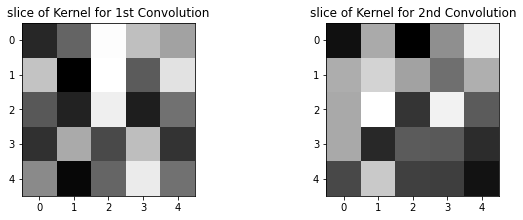

Train Accuracy: 0.47535158395024335 Train Loss: 0.14273564589023582
Test Accuracy: 0.42 Test Loss: 1.616545

Epoch: 9


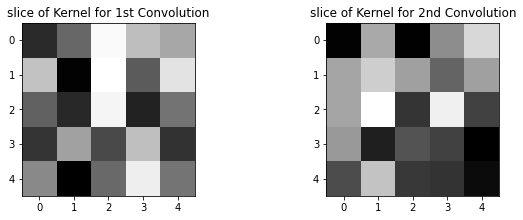

Train Accuracy: 0.5009135762826952 Train Loss: 0.1328017764985561
Test Accuracy: 0.38 Test Loss: 1.7186198

Epoch: 10


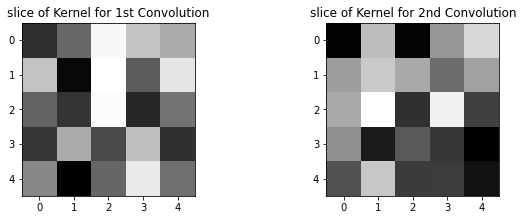

Train Accuracy: 0.5370855444213865 Train Loss: 0.12780670112371448
Test Accuracy: 0.42 Test Loss: 2.031556

Epoch: 11


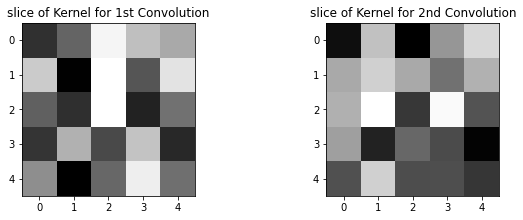

Train Accuracy: 0.5479201986605985 Train Loss: 0.12017703095078466
Test Accuracy: 0.45 Test Loss: 1.570977

Epoch: 12


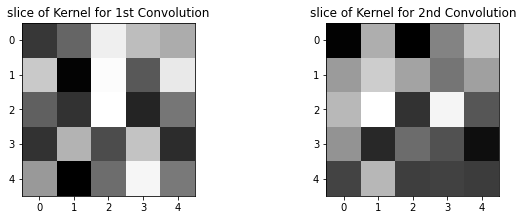

Train Accuracy: 0.5276978582360905 Train Loss: 0.12656802988052374
Test Accuracy: 0.45 Test Loss: 1.5231466

Epoch: 13


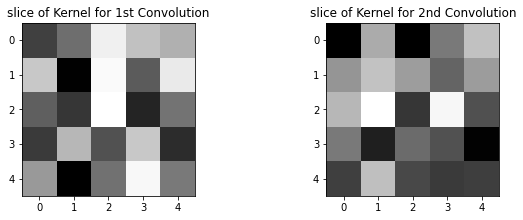

Train Accuracy: 0.570121647515929 Train Loss: 0.11251375365257259
Test Accuracy: 0.48 Test Loss: 1.5616707

Epoch: 14


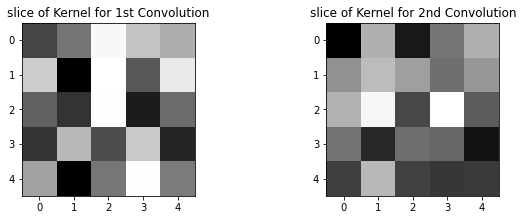

Train Accuracy: 0.589705973355841 Train Loss: 0.11383374428749087
Test Accuracy: 0.46 Test Loss: 1.4516912


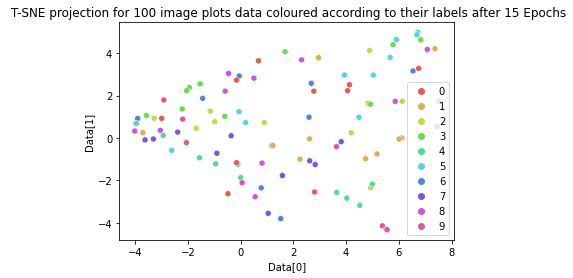


Epoch: 15


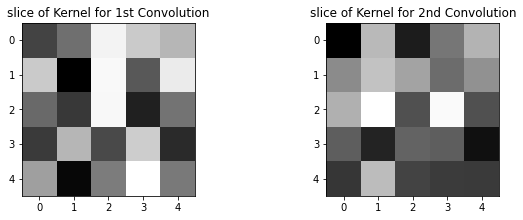

Train Accuracy: 0.5715777535903483 Train Loss: 0.11085345876216887
Test Accuracy: 0.45 Test Loss: 1.6466223
Final accuracy of the classifier: 0.45


In [22]:
print("Considering only Dropout with value 0.8")
model1 = Net(0.8,0)
model1,train_lo,test_lo = Network_model(model1,X_data,Y_label,X_test,Y_test,0,0.8,0,epochs)


<h3>Analysing the train and Test error for the above model and plotting it W.R.T to Epochs </h3>

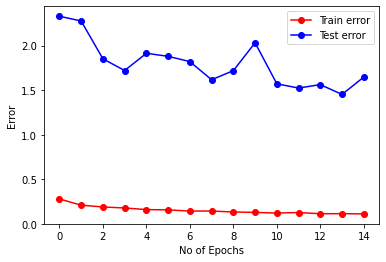

In [23]:
fig_analyse(train_lo,test_lo)

<h2>Observations from plots for 6Q</h2>
<h4>As we can see clearly from the classifier accuracy values of above 3 models where dropout value is changing from 0.2,0.5 and 0.8 we can see that the accuracy is decreasing gradually and also the train and test error is being increased.so larger the dropout value lesser is the accuracy and more is the test_error</h4>

<h3>Considering only Dropout with value 0.2 with vanilla SGD where classifier accuracy,TSNE plot are printed at last</h3>

Considering only Dropout with value 0.2


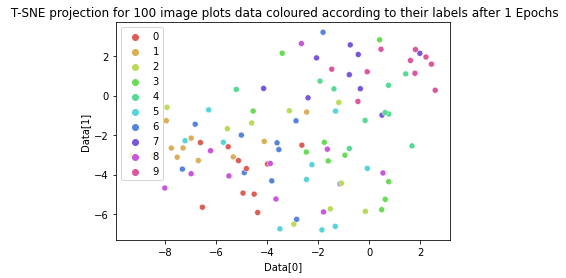


Epoch: 1


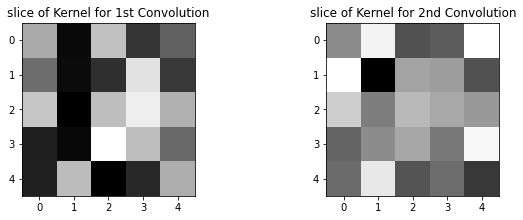

Train Accuracy: 0.14250789077034218 Train Loss: 0.24171683347225187
Test Accuracy: 0.26 Test Loss: 2.000244

Epoch: 2


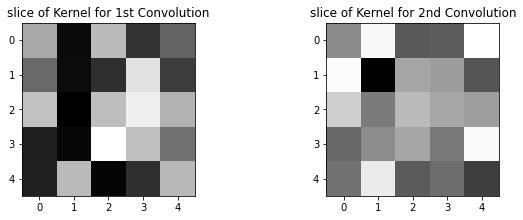

Train Accuracy: 0.3839325212496762 Train Loss: 0.16440903294086454
Test Accuracy: 0.53 Test Loss: 1.4384788

Epoch: 3


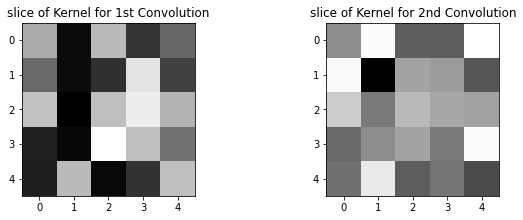

Train Accuracy: 0.6201574105188525 Train Loss: 0.11377173268795017
Test Accuracy: 0.55 Test Loss: 1.3846811

Epoch: 4


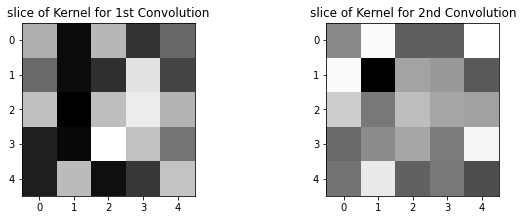

Train Accuracy: 0.7323063588277346 Train Loss: 0.08128878413140772
Test Accuracy: 0.64 Test Loss: 1.0533946

Epoch: 5


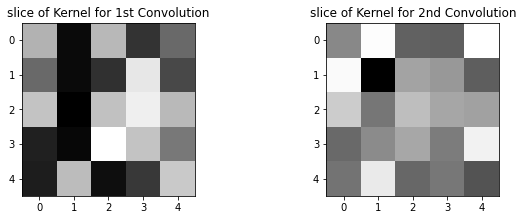

Train Accuracy: 0.7455190070639115 Train Loss: 0.07325827971845865
Test Accuracy: 0.7 Test Loss: 0.9541631

Epoch: 6


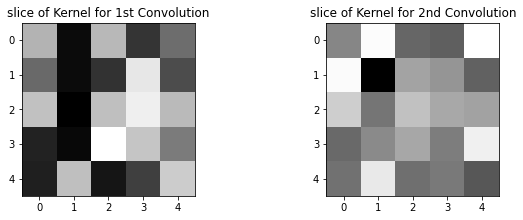

Train Accuracy: 0.8384279437049839 Train Loss: 0.055075862973928455
Test Accuracy: 0.68 Test Loss: 0.8909373

Epoch: 7


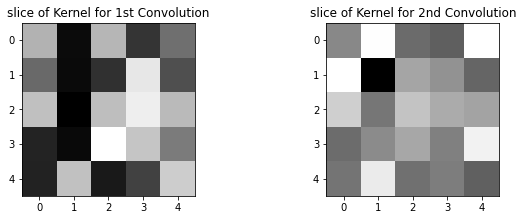

Train Accuracy: 0.8384292486208024 Train Loss: 0.04984850901737811
Test Accuracy: 0.74 Test Loss: 0.8362909

Epoch: 8


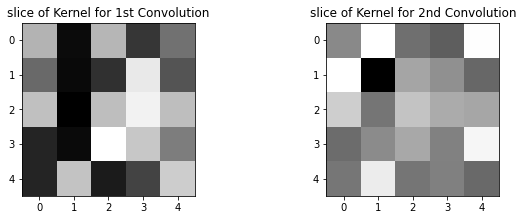

Train Accuracy: 0.8497217769243558 Train Loss: 0.04235041578672825
Test Accuracy: 0.76 Test Loss: 0.7098169

Epoch: 9


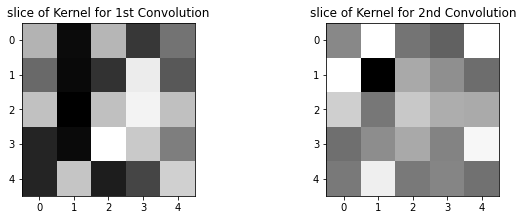

Train Accuracy: 0.8642887965043258 Train Loss: 0.04015595855191349
Test Accuracy: 0.8 Test Loss: 0.7143623

Epoch: 10


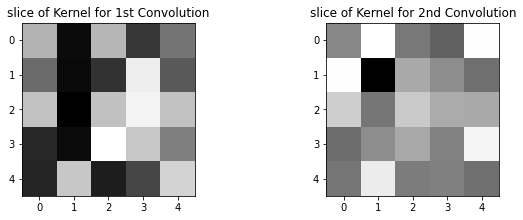

Train Accuracy: 0.8741211313303887 Train Loss: 0.03646810821210967
Test Accuracy: 0.78 Test Loss: 0.6735317

Epoch: 11


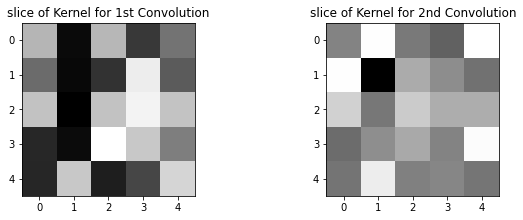

Train Accuracy: 0.8963449215322786 Train Loss: 0.029341243699192984
Test Accuracy: 0.78 Test Loss: 0.685043

Epoch: 12


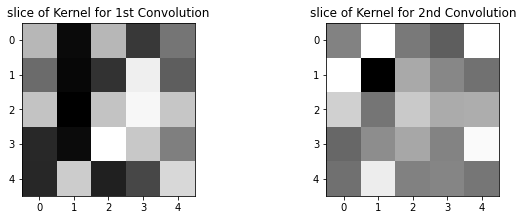

Train Accuracy: 0.9082280594076247 Train Loss: 0.027832735664211218
Test Accuracy: 0.76 Test Loss: 0.6965002

Epoch: 13


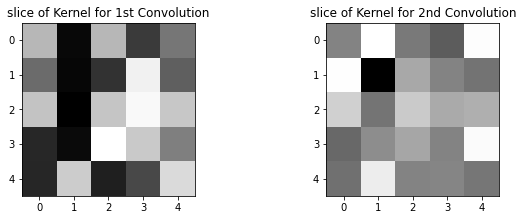

Train Accuracy: 0.9180537436260932 Train Loss: 0.02418582002446056
Test Accuracy: 0.79 Test Loss: 0.7029895

Epoch: 14


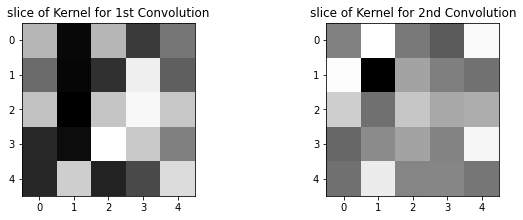

Train Accuracy: 0.923488562187379 Train Loss: 0.02272284500394017
Test Accuracy: 0.81 Test Loss: 0.63460124


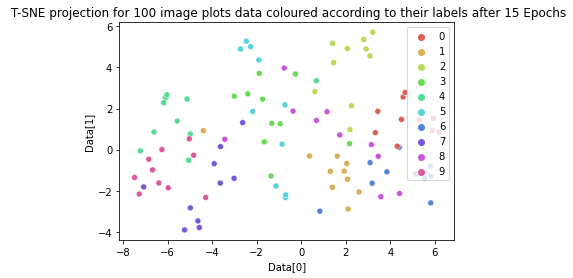


Epoch: 15


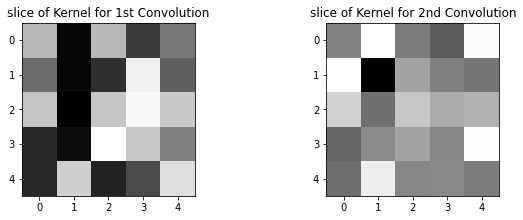

Train Accuracy: 0.9420279571606005 Train Loss: 0.018936353423632684
Test Accuracy: 0.77 Test Loss: 0.70319587
Final accuracy of the classifier: 0.77


In [24]:
print("Considering only Dropout with value 0.2")
model1 = Net(0.2,0)
model1,train_lo,test_lo = Network_model(model1,X_data,Y_label,X_test,Y_test,1,0.2,0,epochs)


<h3>Analysing the train and Test error for the above model and plotting it W.R.T to Epochs </h3>

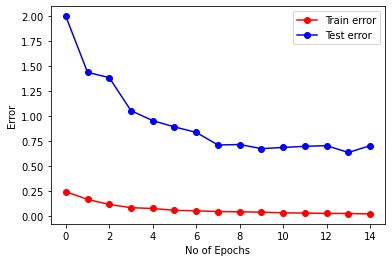

In [25]:
fig_analyse(train_lo,test_lo)

<h3>Considering only Batch Normalization with Vanilla SGD where classifier accuracy,TSNE plot are printed at last</h3>

Considering only Batch Normalization


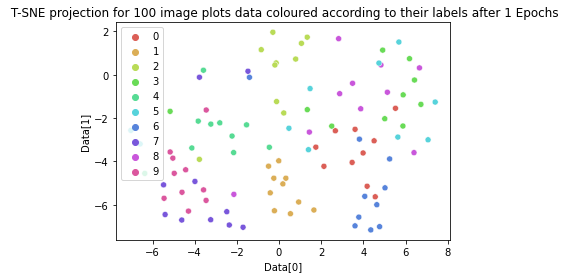


Epoch: 1


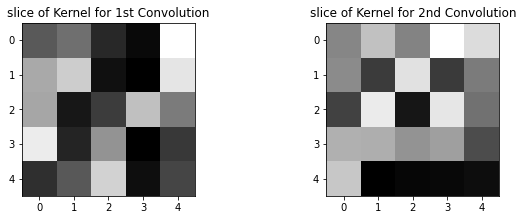

Train Accuracy: 0.2283039317354422 Train Loss: 0.20805688273906708
Test Accuracy: 0.54 Test Loss: 1.4945124

Epoch: 2


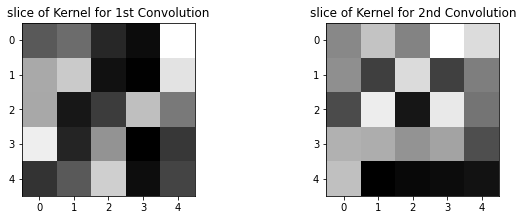

Train Accuracy: 0.5415820576801353 Train Loss: 0.144200240969658
Test Accuracy: 0.63 Test Loss: 1.2864765

Epoch: 3


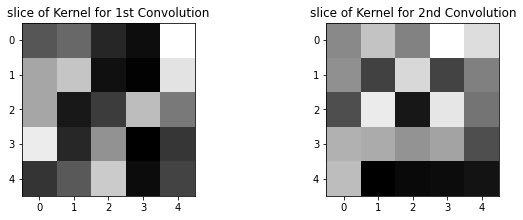

Train Accuracy: 0.611123919512991 Train Loss: 0.13333647352457045
Test Accuracy: 0.68 Test Loss: 1.1846855

Epoch: 4


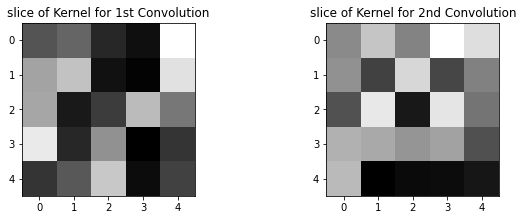

Train Accuracy: 0.6588480951468543 Train Loss: 0.12103655713796618
Test Accuracy: 0.75 Test Loss: 1.1030821

Epoch: 5


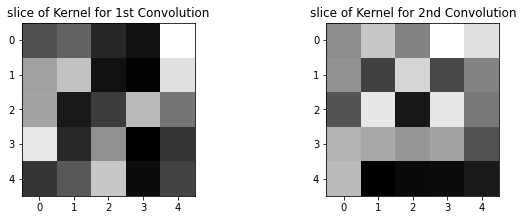

Train Accuracy: 0.7239068694413671 Train Loss: 0.11502367615699764
Test Accuracy: 0.77 Test Loss: 1.0503516

Epoch: 6


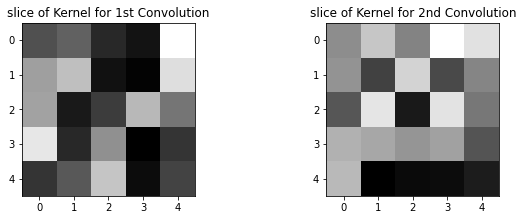

Train Accuracy: 0.769484987419131 Train Loss: 0.11181751251220705
Test Accuracy: 0.77 Test Loss: 1.0121468

Epoch: 7


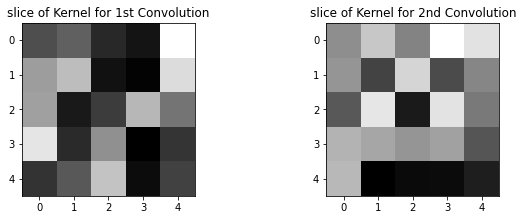

Train Accuracy: 0.7726333061161844 Train Loss: 0.10729611742496488
Test Accuracy: 0.77 Test Loss: 0.99007195

Epoch: 8


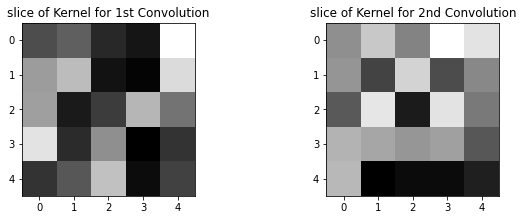

Train Accuracy: 0.7474570707405739 Train Loss: 0.10640201973915098
Test Accuracy: 0.79 Test Loss: 0.966101

Epoch: 9


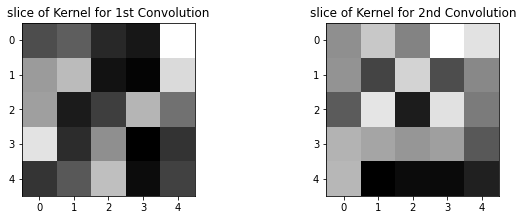

Train Accuracy: 0.7902033282053307 Train Loss: 0.10295295560359956
Test Accuracy: 0.79 Test Loss: 0.939012

Epoch: 10


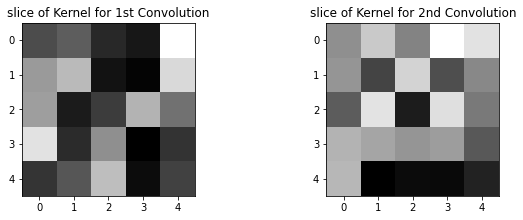

Train Accuracy: 0.7728477670011696 Train Loss: 0.10146082156896594
Test Accuracy: 0.79 Test Loss: 0.91198397

Epoch: 11


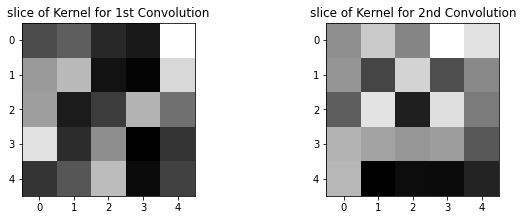

Train Accuracy: 0.7828633017174191 Train Loss: 0.1002683409452438
Test Accuracy: 0.79 Test Loss: 0.90657175

Epoch: 12


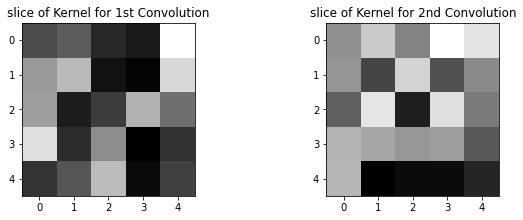

Train Accuracy: 0.8113740750600883 Train Loss: 0.09681084883213048
Test Accuracy: 0.82 Test Loss: 0.88862526

Epoch: 13


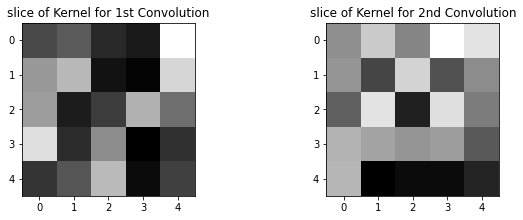

Train Accuracy: 0.8154960451200366 Train Loss: 0.09471060621738432
Test Accuracy: 0.82 Test Loss: 0.87536705

Epoch: 14


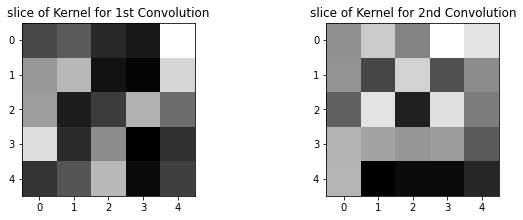

Train Accuracy: 0.7917996211718745 Train Loss: 0.09351225972175597
Test Accuracy: 0.82 Test Loss: 0.862814


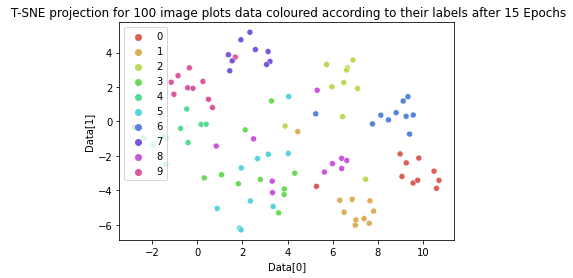


Epoch: 15


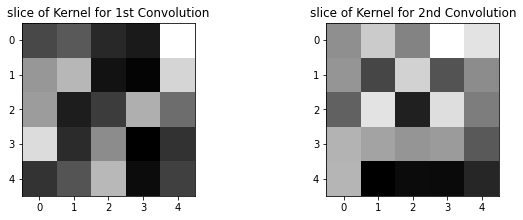

Train Accuracy: 0.8162942526243502 Train Loss: 0.09357085627317425
Test Accuracy: 0.84 Test Loss: 0.845709
Final accuracy of the classifier: 0.84


In [26]:
print("Considering only Batch Normalization")
model1 = Net(0,1)
model1,train_lo,test_lo = Network_model(model1,X_data,Y_label,X_test,Y_test,1,0,1,epochs)


<h3>Analysing the train and Test error for the above model and plotting it W.R.T to Epochs </h3>

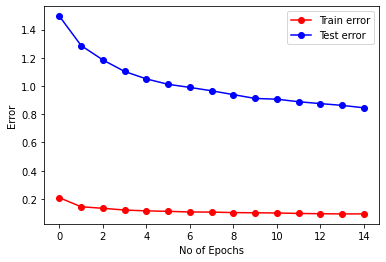

In [27]:
fig_analyse(train_lo,test_lo)

<h3>Considering both Dropout with value 0.2 and Batch Normalization with Vanilla SGD where classifier accuracy,TSNE plot are printed at last</h3>

Considering both Dropout and Batch Normalization


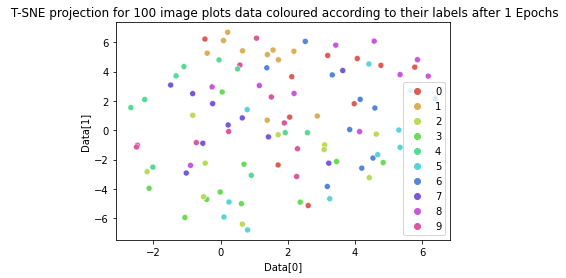


Epoch: 1


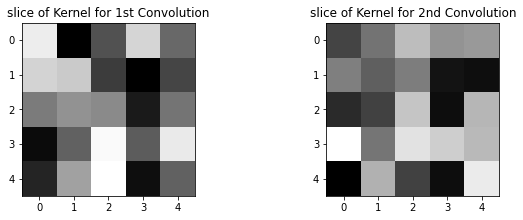

Train Accuracy: 0.15604309337248365 Train Loss: 0.22144908595085142
Test Accuracy: 0.32 Test Loss: 1.9207207

Epoch: 2


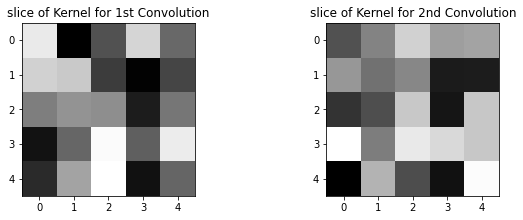

Train Accuracy: 0.33786697644665753 Train Loss: 0.17745394730567934
Test Accuracy: 0.45 Test Loss: 1.7059381

Epoch: 3


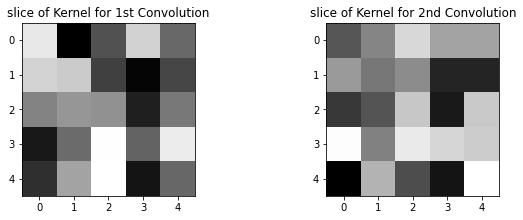

Train Accuracy: 0.446018326661193 Train Loss: 0.1628366922140122
Test Accuracy: 0.5 Test Loss: 1.5647198

Epoch: 4


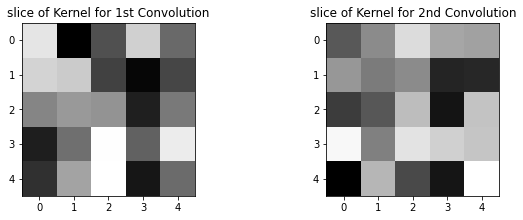

Train Accuracy: 0.5499371811519927 Train Loss: 0.15133784663677213
Test Accuracy: 0.56 Test Loss: 1.521093

Epoch: 5


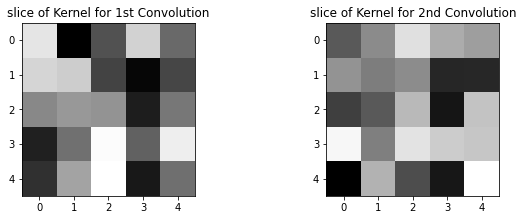

Train Accuracy: 0.5980807040403394 Train Loss: 0.14202004289627074
Test Accuracy: 0.57 Test Loss: 1.442787

Epoch: 6


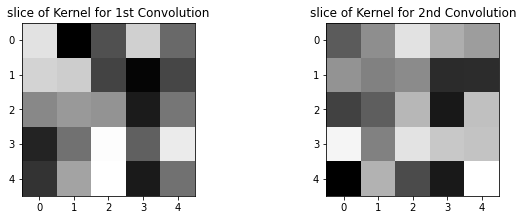

Train Accuracy: 0.59246558530734 Train Loss: 0.1380716383457184
Test Accuracy: 0.65 Test Loss: 1.31639

Epoch: 7


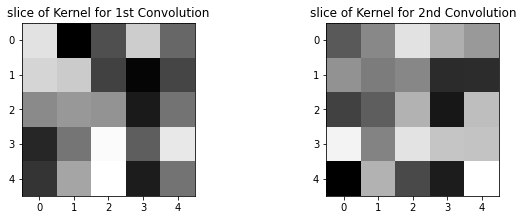

Train Accuracy: 0.5811917874260657 Train Loss: 0.13553508615493776
Test Accuracy: 0.67 Test Loss: 1.3287475

Epoch: 8


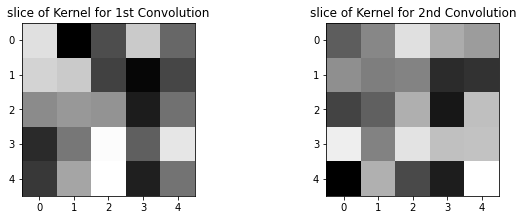

Train Accuracy: 0.6214044796069114 Train Loss: 0.12785790985822676
Test Accuracy: 0.65 Test Loss: 1.2625859

Epoch: 9


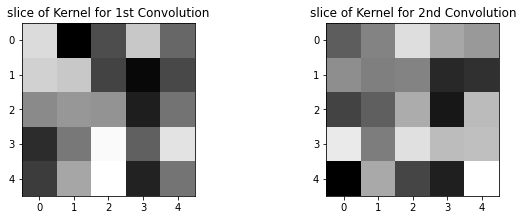

Train Accuracy: 0.6563253109761576 Train Loss: 0.12721766823530195
Test Accuracy: 0.72 Test Loss: 1.1944184

Epoch: 10


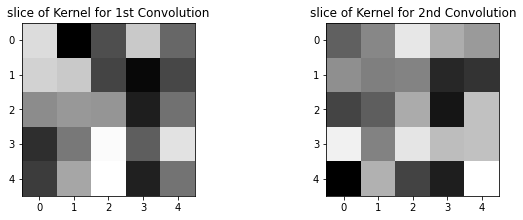

Train Accuracy: 0.6599555643755127 Train Loss: 0.12187045001983643
Test Accuracy: 0.76 Test Loss: 1.1867541

Epoch: 11


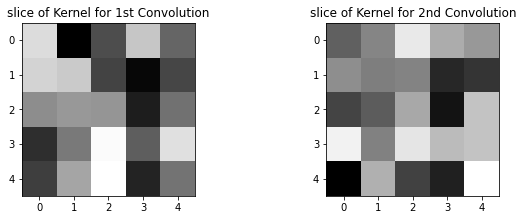

Train Accuracy: 0.706380570896853 Train Loss: 0.1178294022083282
Test Accuracy: 0.71 Test Loss: 1.1348215

Epoch: 12


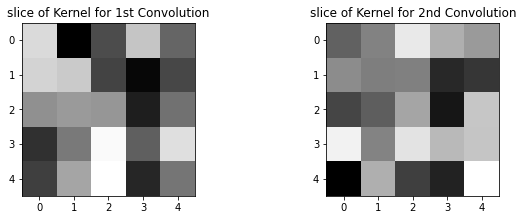

Train Accuracy: 0.693133299373793 Train Loss: 0.11667384970188138
Test Accuracy: 0.72 Test Loss: 1.0754822

Epoch: 13


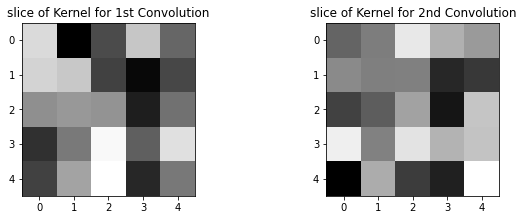

Train Accuracy: 0.7069412607954281 Train Loss: 0.11567065906524654
Test Accuracy: 0.73 Test Loss: 1.0728426

Epoch: 14


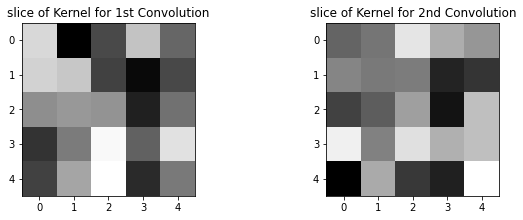

Train Accuracy: 0.7456094018227867 Train Loss: 0.1102389554977417
Test Accuracy: 0.78 Test Loss: 1.0416065


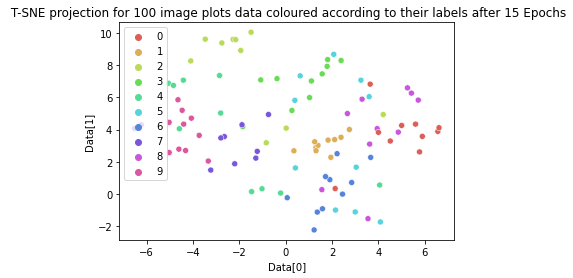


Epoch: 15


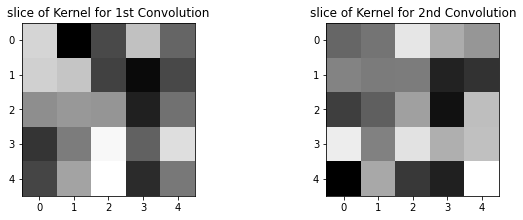

Train Accuracy: 0.7656171016390333 Train Loss: 0.1093763931393623
Test Accuracy: 0.76 Test Loss: 1.0803728
Final accuracy of the classifier: 0.76


In [28]:
print("Considering both Dropout and Batch Normalization")
model1 = Net(0.2,1)
model1,train_lo,test_lo = Network_model(model1,X_data,Y_label,X_test,Y_test,1,0.2,1,epochs)

<h3>Analysing the train and Test error for the above model and plotting it W.R.T to Epochs where classifier accuracy,TSNE plot are printed at last</h3>

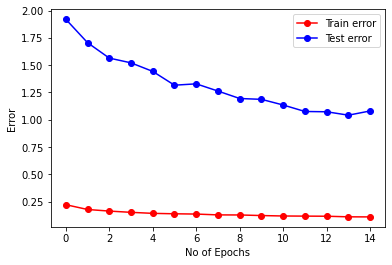

In [29]:
fig_analyse(train_lo,test_lo)

<h2>Observations from plots for 7Q</h2>
<h4>As we can see from the classifier accuracy values of above 3 models when we apply batch normalization keeping the dropout value constant(0.2) and removing it for one trial we can see that the accuracy is little increasing when we are using batch normalization and also the train and test error is slightly being decreased.</h4>